# Overview

This notebook performs **Bayesian stress testing** on a small portfolio of loans using user-provided priors and observed data. The key objectives of the code are:

- **User-Provided Priors**: Allows users to input their own prior beliefs for the **Probability of Default (PD)** and **Loss Given Default (LGD)**.
- **Data Incorporation**: Updates these priors with observed data (number of defaults) to obtain posterior distributions through Bayesian inference.
- **Expected Loss Calculations**: Calculates expected losses under both baseline (median values) and stressed (95th percentile values) scenarios based on the posterior distributions.
- **Visualization**: Provides visualizations of the posterior distributions to understand how the priors are updated by the data.
- **Flexibility**: Enables users to adjust their assumptions and observe the impact on expected losses, enhancing risk assessment and decision-making.

## Key Components of the Code

- **Function `bayesian_stress_test`**:
  - **Inputs**:
    - `n_loans`: Total number of loans.
    - `n_defaults`: Number of observed defaults (data input).
    - `prior_params_pd`: Tuple `(alpha_pd, beta_pd)` representing the user-provided prior for PD.
    - `prior_params_lgd`: Tuple `(alpha_lgd, beta_lgd)` representing the user-provided prior for LGD.
    - `ead`: Exposure at Default per loan (default is \$1,000,000).
  - **Process**:
    - Builds a Bayesian model incorporating the priors and observed data.
    - Performs Markov Chain Monte Carlo (MCMC) sampling to obtain posterior distributions.
    - Calculates baseline and stressed expected losses.
  - **Outputs**:
    - `trace`: Posterior samples for PD and LGD.
    - `results`: Dictionary containing baseline and stressed PD, LGD, and expected losses.

- **Error Suppression**:
  - Suppresses specific OS error messages to ensure clean output.

- **Example Usage**:
  - Demonstrates how to input priors and observed data.
  - Performs the stress test and displays results.
  - Visualizes the posterior distributions of PD and LGD.

## How to Use This Notebook

1. **Define Observed Data**:
   - Set the number of loans (`n_loans`) and the number of observed defaults (`n_defaults`).

2. **Input Priors**:
   - Specify your prior beliefs for PD and LGD by setting the `alpha` and `beta` parameters of the Beta distributions.

3. **Run the Stress Test**:
   - Call the `bayesian_stress_test` function with your inputs.
   - Obtain the posterior distributions and expected losses.

4. **Interpret Results**:
   - Examine the baseline and stressed expected losses.
   - Use the visualizations to understand how the data has updated your priors.

5. **Adjust Assumptions**:
   - Experiment with different priors or observed data.
   - Observe how changes affect the expected losses and posterior distributions.

## Purpose and Benefits

- **Incorporates Expert Knowledge**: By allowing user-defined priors, the model incorporates expert opinions and beliefs.
- **Data-Driven Updating**: Observed data refines the priors to produce informed posterior estimates.
- **Risk Assessment**: Calculating expected losses under different scenarios aids in evaluating potential risks.
- **Decision Support**: Provides a quantitative foundation for making informed credit risk management decisions.

---

*This Bayesian approach enables effective stress testing with limited data, combining expert judgment with statistical inference to enhance risk analysis and decision-making processes.*


In [ ]:
!pip install numpy==1.22.1 scipy==1.7.3 pymc

Output()

Output()

Results:
Baseline PD (Median): 0.0337
Baseline LGD (Median): 0.2850
Stressed PD (95th Percentile): 0.0698
Stressed LGD (95th Percentile): 0.5532
Baseline Expected Loss: $9,604.25
Stressed Expected Loss: $38,630.38


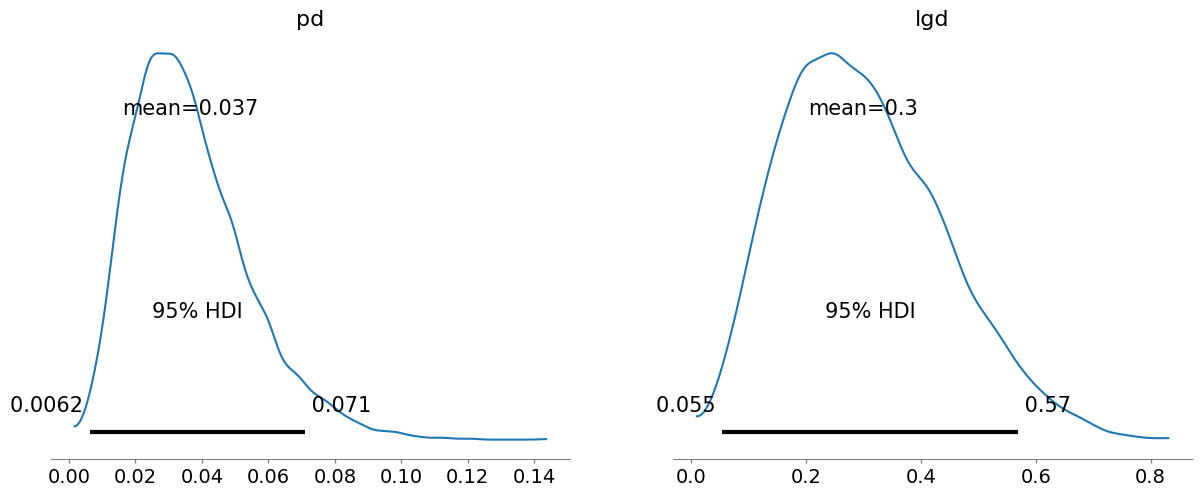

In [4]:
# Import necessary libraries
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import sys
import contextlib
import warnings
import logging

# Suppress warnings and specific error messages
warnings.filterwarnings('ignore')
logging.getLogger('theano').setLevel(logging.ERROR)

@contextlib.contextmanager
def suppress_specific_stderr(text):
    class FilterStderr:
        def __init__(self):
            self.stderr = sys.stderr
        def write(self, message):
            if text not in message:
                self.stderr.write(message)
        def flush(self):
            self.stderr.flush()
    old_stderr = sys.stderr
    sys.stderr = FilterStderr()
    try:
        yield
    finally:
        sys.stderr = old_stderr

# Function to perform Bayesian stress test with user-provided priors
def bayesian_stress_test(n_loans, n_defaults, prior_params_pd, prior_params_lgd, ead=1_000_000):
    """
    Performs Bayesian stress testing with user-provided priors.

    Parameters:
    - n_loans: int, total number of loans
    - n_defaults: int, number of observed defaults
    - prior_params_pd: tuple, (alpha_pd, beta_pd) parameters for PD prior
    - prior_params_lgd: tuple, (alpha_lgd, beta_lgd) parameters for LGD prior
    - ead: float, Exposure at Default per loan (default is 1,000,000)

    Returns:
    - trace: posterior trace from MCMC sampling
    - results: dictionary containing baseline and stressed expected losses
    """
    # Unpack prior parameters
    alpha_prior_pd, beta_prior_pd = prior_params_pd
    alpha_prior_lgd, beta_prior_lgd = prior_params_lgd

    # Suppress specific error messages during model execution
    with suppress_specific_stderr("cannot open shared object file"):
        # Build the model
        with pm.Model() as model:
            # Prior for PD
            pd = pm.Beta('pd', alpha=alpha_prior_pd, beta=beta_prior_pd)

            # Prior for LGD
            lgd = pm.Beta('lgd', alpha=alpha_prior_lgd, beta=beta_prior_lgd)

            # Likelihood for defaults (Data incorporation)
            defaults_observed = pm.Binomial('defaults_observed', n=n_loans, p=pd, observed=n_defaults)

            # Sampling
            trace = pm.sample(5000, tune=1000, target_accept=0.95, random_seed=42, return_inferencedata=True)

    # Extract posterior samples
    pd_samples = trace.posterior['pd'].values.flatten()
    lgd_samples = trace.posterior['lgd'].values.flatten()

    # Baseline Values (Median)
    pd_median = np.percentile(pd_samples, 50)
    lgd_median = np.percentile(lgd_samples, 50)

    # Stressed Values (95th Percentile)
    pd_95th = np.percentile(pd_samples, 95)
    lgd_95th = np.percentile(lgd_samples, 95)

    # Expected Loss Calculations
    expected_loss_baseline = ead * pd_median * lgd_median
    expected_loss_stressed = ead * pd_95th * lgd_95th

    # Compile results
    results = {
        'Baseline PD (Median)': pd_median,
        'Baseline LGD (Median)': lgd_median,
        'Stressed PD (95th Percentile)': pd_95th,
        'Stressed LGD (95th Percentile)': lgd_95th,
        'Baseline Expected Loss': expected_loss_baseline,
        'Stressed Expected Loss': expected_loss_stressed
    }

    return trace, results

# Example usage of the function
if __name__ == "__main__":
    # Data
    n_loans = 10           # Total number of loans
    n_defaults = 1         # Number of observed defaults

    # User-provided priors for PD and LGD
    # Users can adjust the alpha and beta parameters as per their beliefs

    # Example prior for PD: User believes PD ≈ 3%
    prior_params_pd = (3, 97)   # Alpha = 3, Beta = 97 (Mean PD ≈ 3%)

    # Example prior for LGD: User believes LGD ≈ 70%
    prior_params_lgd = (3, 7)   # Alpha = 7, Beta = 3 (Mean LGD ≈ 70%)

    # Perform Bayesian stress test
    trace, results = bayesian_stress_test(n_loans, n_defaults, prior_params_pd, prior_params_lgd)

    # Display results
    print("Results:")
    for key, value in results.items():
        if 'Expected Loss' in key:
            print(f"{key}: ${value:,.2f}")
        else:
            print(f"{key}: {value:.4f}")

    # Visualize the posterior distributions
    az.plot_posterior(trace, var_names=['pd', 'lgd'], hdi_prob=0.95)
    plt.show()
